# Przygotowanie odpowiednich danych

In [1]:
# Jeśli zajdzie potrzeba
# from google.colab import drive

# drive.mount('/content/drive')

In [2]:
'''
Dla PoC wykonuje obliczenia dla:
 * '../data/DogsCats'
Folder docelowy:
 * '../data/Photos'
 
Wilkość zdjęcia zależna od urzytego rozwiązania:
 * dla CNN będzie to 128(np. dla ResNetu - 224)
'''

dir_path = '../data/DogsCats'
image_size = 128 # Wielkość zdjęć Resnetu

#  Sprawdzanie środowiska

In [3]:
from platform import python_version

print(python_version())

3.7.0


# Załadowanie danych

In [4]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


# Stałe

In [5]:
# IMAGE_WIDTH=128
# IMAGE_HEIGHT=128
# IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Przygotowanie Danych

In [6]:
'''
Opis danych:
1 - klasa 1
0 - klasa 2
'''

dir_vars = os.listdir(dir_path + '/train') 

A_folder = os.listdir(dir_path + '/train/' + dir_vars[0])
B_folder = os.listdir(dir_path + '/train/' + dir_vars[1])

filenames = []
categories = []
for filename in A_folder:
    categories.append(1)
    filenames.append(filename)

for filename in B_folder:
    categories.append(0)
    filenames.append(filename)


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [7]:
# Mieszamy!
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,filename,category
0,cat.7740.jpg,0
1,dog.9963.jpg,1
2,dog.4764.jpg,1
3,dog.4344.jpg,1
4,cat.9257.jpg,0


In [9]:
df.shape

(20000, 2)

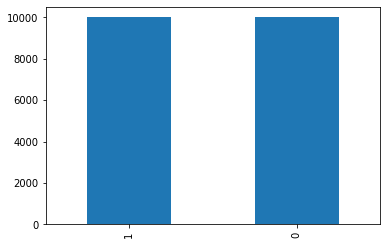

In [10]:
df['category'].value_counts().plot.bar()

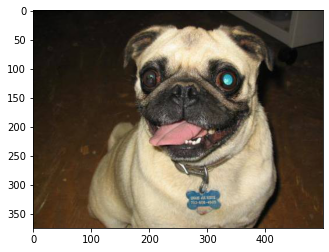

In [11]:
sample = random.choice(A_folder)
path = dir_path + '/train/' + dir_vars[0] + '/'
image = load_img(path + sample)
plt.imshow(image)

# Obróbka danych

In [12]:
train_df = df

dir_vars = os.listdir(dir_path + '/test') 

A_folder = os.listdir(dir_path + '/test/' + dir_vars[0])
B_folder = os.listdir(dir_path + '/test/' + dir_vars[1])

filenames = []
categories = []
for filename in A_folder:
    categories.append(1)
    filenames.append(filename)

for filename in B_folder:
    categories.append(0)
    filenames.append(filename)


validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

if 'DogsCats' in dir_path:
    train_df['category'] = train_df['category'].replace({0: 'cat', 1: 'dog'}) 
    validate_df['category'] = validate_df['category'].replace({0: 'cat', 1: 'dog'})
else:
    train_df['category'] = train_df['category'].replace({0: 'originals', 1: 'photoshops'}) 
    validate_df['category'] = validate_df['category'].replace({0: 'originals', 1: 'photoshops'})

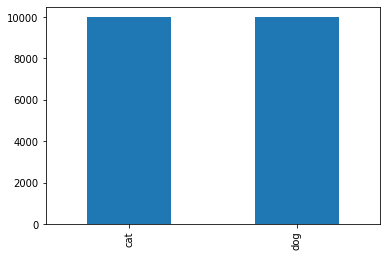

In [13]:
train_df['category'].value_counts().plot.bar()

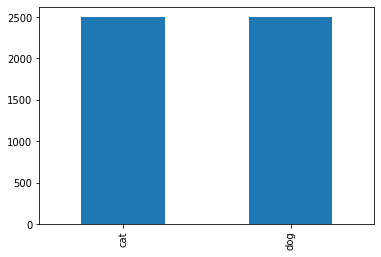

In [14]:
validate_df['category'].value_counts().plot.bar()

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 10

# Generatory

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_directory(
    directory=dir_path + '/train', 
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory( 
    directory=dir_path + '/test',
    target_size=(image_size, image_size),
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 images belonging to 2 classes.


In [18]:
sample = random.choice(A_folder)
path = dir_path + '/test/' + dir_vars[0] + '/'

example_df = pd.DataFrame({
    'filename': [sample],
    'category': [path.split('/')[-2][:-1]]
})

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory=path,
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


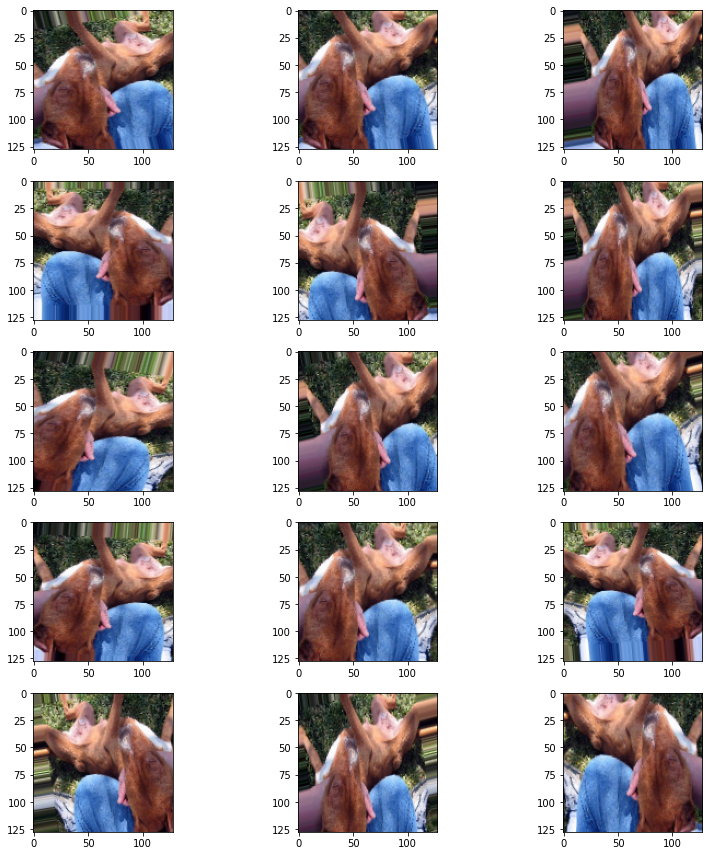

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Callbacki

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
import keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [21]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
EARLY_STOP_PATIENCE = 10

# monitor = 'val_loss', 
cb_early_stopper = EarlyStopping(patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [23]:
ConfusionMatrixY = []
ConfusionMatrixYpred = []


def plot_cm(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    df_cm = pd.DataFrame(cm)
    sns.heatmap(df_cm, cmap="Blues", annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Macierz konfuzji')

In [24]:
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Model

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

# Fit

In [26]:
epochs = 50

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', get_f1])

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=200, #total_validate//batch_size,
    steps_per_epoch=200, #total_train//batch_size,
    callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction]
)

# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis
model.save('the_best.h5')

Epoch 1/50
200/200 [==============================] - 89s 443ms/step - loss: 1.2156 - accuracy: 0.5505 - get_f1: 0.5505 - val_loss: 1.6927 - val_accuracy: 0.4920 - val_get_f1: 0.4920
Epoch 2/50
200/200 [==============================] - 91s 454ms/step - loss: 0.8811 - accuracy: 0.5735 - get_f1: 0.5735 - val_loss: 0.8914 - val_accuracy: 0.5610 - val_get_f1: 0.5610
Epoch 3/50
200/200 [==============================] - 88s 440ms/step - loss: 0.7530 - accuracy: 0.5970 - get_f1: 0.5970 - val_loss: 0.9068 - val_accuracy: 0.6000 - val_get_f1: 0.6000
Epoch 4/50
200/200 [==============================] - 89s 445ms/step - loss: 0.7231 - accuracy: 0.5950 - get_f1: 0.5950 - val_loss: 0.6040 - val_accuracy: 0.5155 - val_get_f1: 0.5155
Epoch 5/50
200/200 [==============================] - 88s 441ms/step - loss: 0.6777 - accuracy: 0.6150 - get_f1: 0.6150 - val_loss: 0.7438 - val_accuracy: 0.5995 - val_get_f1: 0.5995

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoc

# Statystyki

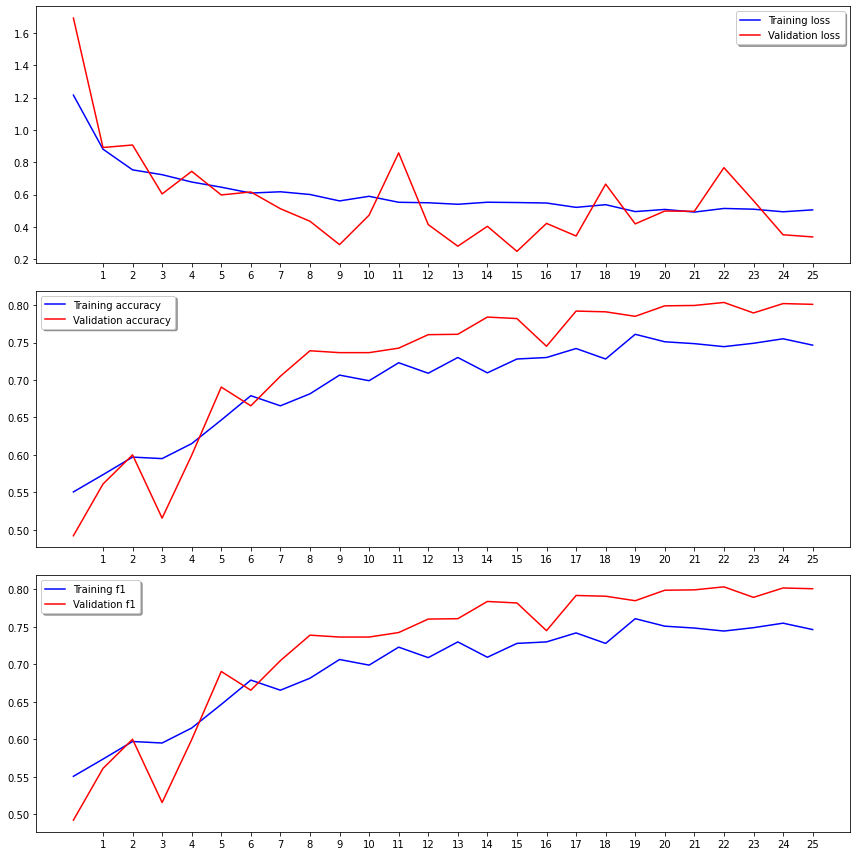

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(1, len(history.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(1, len(history.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)

ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(1, len(history.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [178]:
dir_vars = os.listdir(dir_path + '/test') 

A_folder = os.listdir(dir_path + '/test/' + dir_vars[0])
B_folder = os.listdir(dir_path + '/test/' + dir_vars[1])

filenames = []
categories = []
for filename in A_folder:
    categories.append(1)
    filenames.append(dir_path + '/test/' + dir_vars[0] + '/' + filename)

for filename in B_folder:
    categories.append(0)
    filenames.append(dir_path + '/test/' + dir_vars[1] + '/' + filename)


stats_df = pd.DataFrame({
    'filename': filenames,
    'category': categories,
    'predict': None
})
# Mieszamy!
stats_df = stats_df.sample(frac=1).reset_index(drop=True)


stats_df.head()

,filename,category,predict
0,../data/DogsCats/test/cats/cat.10222.jpg,0,None
1,../data/DogsCats/test/cats/cat.10170.jpg,0,None
2,../data/DogsCats/test/cats/cat.10857.jpg,0,None
3,../data/DogsCats/test/dogs/dog.11934.jpg,1,None
4,../data/DogsCats/test/dogs/dog.10733.jpg,1,None


In [195]:
from keras.preprocessing import image

for idx, row in stats_df.iterrows():
    img_path = row['filename']
    img = image.load_img(img_path, color_mode='rgb', target_size=(image_size, image_size))
    x = image.img_to_array(img)
    x = numpy.expand_dims(x, axis=0)
    pred = model.predict(x, verbose=False)
    stats_df.at[idx, 'predict'] = int(numpy.argmax(pred, axis=-1))

In [213]:
stats_df.head()

,filename,category,predict
0,../data/DogsCats/test/cats/cat.10222.jpg,0,0
1,../data/DogsCats/test/cats/cat.10170.jpg,0,0
2,../data/DogsCats/test/cats/cat.10857.jpg,0,0
3,../data/DogsCats/test/dogs/dog.11934.jpg,1,0
4,../data/DogsCats/test/dogs/dog.10733.jpg,1,0


In [205]:
ConfusionMatrixY = stats_df['category'].to_numpy()
ConfusionMatrixYpred = stats_df['predict'].to_numpy().astype(int)

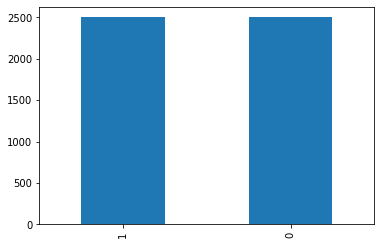

In [206]:
stats_df['category'].value_counts().plot.bar()

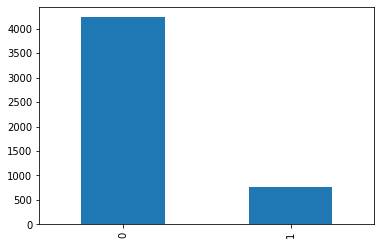

In [207]:
stats_df['predict'].value_counts().plot.bar()

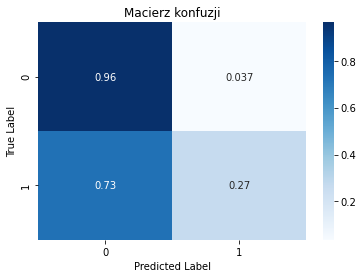

In [209]:
cm = confusion_matrix(ConfusionMatrixY, ConfusionMatrixYpred)
plot_cm(cm)

In [210]:
print(cm)

[[2408   92]
 [1824  676]]


In [211]:
accuracy, precision, recall, fscore = countStats(ConfusionMatrixY, ConfusionMatrixYpred)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.6168
Precision: 0.7246032214870826
Recall: 0.6168
F-score: 0.5645489381539492
